In [38]:
using Clustering
using LinearAlgebra
using Plots
using Random
Random.seed!(1234);  # determinism

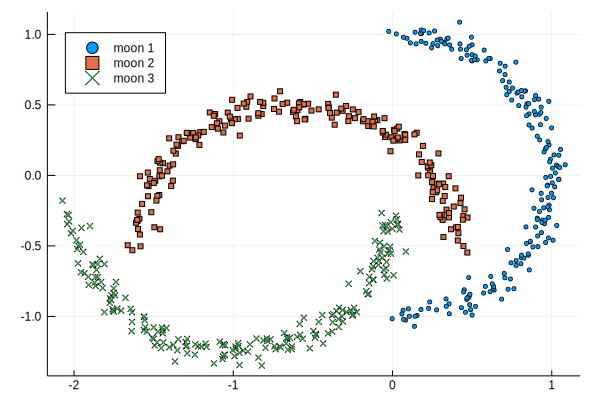

In [39]:
# Three moons
N = 200;
t = sort(rand(N) * π)
moon1 = [sin.(t) cos.(t)] .+ 0.05 * randn(N,2)
moon2 = [cos.(t) .- 0.1 sin.(t)] .+ 0.05 * randn(N,2) .- 0.5
moon3 = [cos.(t) .- 1.0 -sin.(t) .- 0.25] .+ 0.05 * randn(N,2)
moons = [moon1; moon2; moon3]
scatter( moon1[:,1], moon1[:,2], marker=:circle, markersize=2, label="moon 1", legend=:topleft)
scatter!(moon2[:,1], moon2[:,2], marker=:square, markersize=2, label="moon 2")
scatter!(moon3[:,1], moon3[:,2], marker=:X,      markersize=2, label="moon 3")

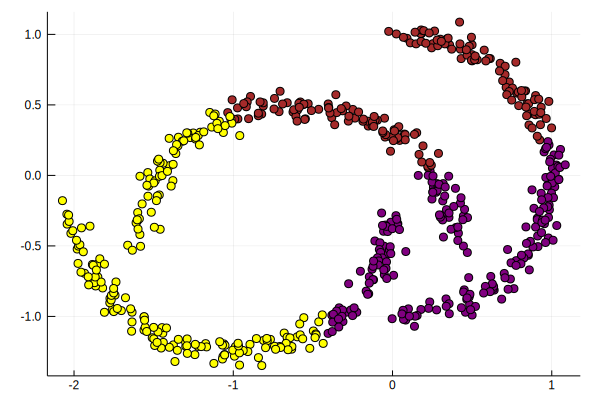

In [40]:
assignments = kmeans(moons', 3).assignments
inds1, inds2, inds3 = [findall(assignments .== i) for i = 1:3]
scatter( moons[inds1,1], moons[inds1,2], color="purple", label="")
scatter!(moons[inds2,1], moons[inds2,2], color="brown",  label="")
scatter!(moons[inds3,1], moons[inds3,2], color="yellow", label="")
title!("K-means clustering")

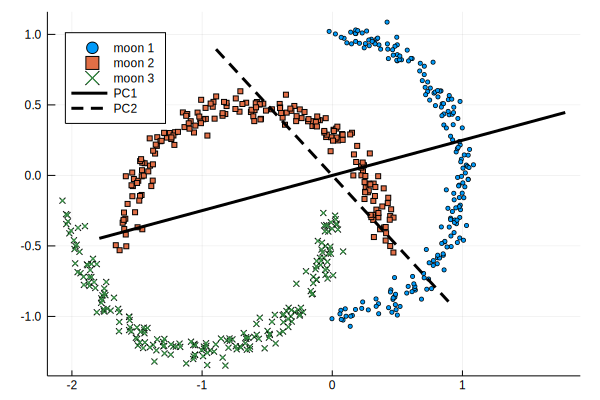

In [41]:
F = svd(moons)
V = F.V
dir1x, dir1y = 2 * [-V[1,1], V[1,1]], [-V[2,1], V[2,1]]
dir2x, dir2y = 2 * [-V[1,2], V[1,2]], [-V[2,2], V[2,2]]
scatter( moon1[:,1], moon1[:,2], marker=:circle, markersize=2, label="moon 1", legend=:topleft)
scatter!(moon2[:,1], moon2[:,2], marker=:square, markersize=2, label="moon 2")
scatter!(moon3[:,1], moon3[:,2], marker=:X,      markersize=2, label="moon 3")
plot!(dir1x, dir1y, lw=3, color="black", label="PC1")
plot!(dir2x, dir2y, lw=3, color="black", label="PC2", 
      ls=:dash, legend=:topleft)

┌ Warning: implicit `dims=2` argument now has to be passed explicitly to specify that distances between columns should be computed
│   caller = _kmeans!(::Adjoint{Float64,Array{Float64,1}}, ::Nothing, ::Array{Float64,2}, ::Array{Int64,1}, ::Array{Float64,1}, ::Array{Int64,1}, ::Array{Float64,1}, ::Int64, ::Float64, ::Int64, ::Distances.SqEuclidean) at kmeans.jl:115
└ @ Clustering /Users/arb/.julia/packages/Clustering/pvAp6/src/kmeans.jl:115


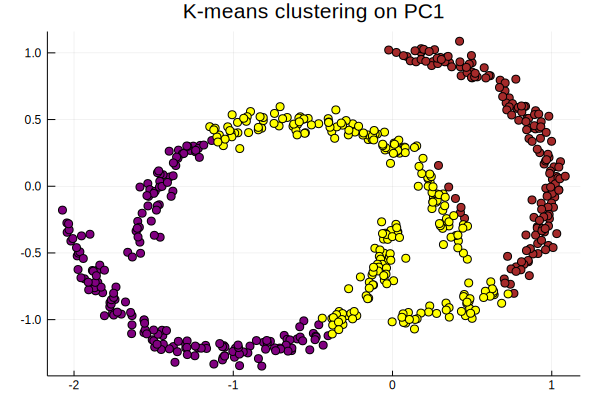

In [42]:
X = moons * V
PC1 = X[:,1]

assignments = kmeans(PC1', 3).assignments
inds1, inds2, inds3 = [findall(assignments .== i) for i = 1:3]
scatter( moons[inds1,1], moons[inds1,2], color="purple", label="")
scatter!(moons[inds2,1], moons[inds2,2], color="brown",  label="")
scatter!(moons[inds3,1], moons[inds3,2], color="yellow", label="")
title!("K-means clustering on PC1")

In [47]:
# Isomap
function isomap(X, K)
    n = size(X, 1)
    D = zeros(n, n)
    # all-pairs distances
    for i = 1:n, j = i:n
        D[i, j] = norm(vec(moons[i,:]) - vec(moons[j,:]), 2)
    end
    # k-nearest neighbors
    DX = zeros(n, n)
    for i = 1:n
        knn = sortperm(D[:, i])[2:(K+1)]
        DX[knn, i] = D[knn, i]
        DX[i, knn] = D[i, knn]
    end
    # shortest paths
    DG = Inf * ones(n, n)
    for i = 1:n, j = 1:n
        if DX[i, j] > 0; DG[i, j] = DX[i, j] end
    end
    DG = min.(DG, DG')
    for k = 1:n, j = 1:n, i = 1:n
        #if k == n; @show DG[i, j], DG[i, k] + DG[k, j]; end
        DG[i, j] = min(DG[i, j], DG[i, k] + DG[k, j])
        DG[j, i] = DG[i, j]
        #if k == n; @show DG[i, j]; end
    end
    H = (I - ones(n, n) / n)  # centering matrix
    τG = -H * (DG .^ 2) * H / 2
    Λ, V = eigen(τG)
    return DG, Λ, V
end
DG, Λ, V = isomap(moons, 5)

([0.100904 0.0513424 … 12.2118 12.3207; 0.0513424 0.102685 … 12.2629 12.3719; … ; 12.2118 12.2629 … 0.0249361 0.109373; 12.3207 12.3719 … 0.109373 0.199782], [8365.21, 26.1997, -9.76333, 6.94985, 4.45029, 2.77142, -2.29911, 1.67099, -1.42522, 1.17234  …  -0.000555076, -0.000525624, -0.0005112, -0.000479575, -0.000385614, -0.000365528, -0.000338764, -0.000427735, -0.000427694, -0.000429244], [0.0644845 -0.0497672 … 8.38726e-8 7.55361e-11; 0.0650419 -0.0503005 … 6.66992e-7 -2.39319e-10; … ; -0.0689835 -0.047239 … 0.00447014 -0.0328688; -0.0701717 -0.0484071 … 0.000128449 -0.00104517])

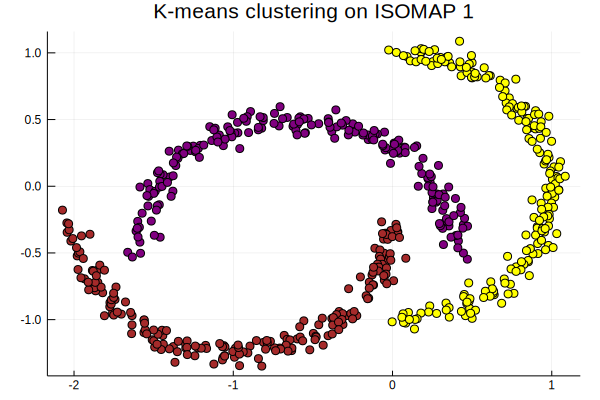

In [48]:
X = sqrt(Λ[1]) * V[:, 1]
assignments = kmeans(X', 3).assignments
inds1, inds2, inds3 = [findall(assignments .== i) for i = 1:3]
scatter( moons[inds1,1], moons[inds1,2], color="purple", label="")
scatter!(moons[inds2,1], moons[inds2,2], color="brown",  label="")
scatter!(moons[inds3,1], moons[inds3,2], color="yellow", label="")
title!("K-means clustering on ISOMAP 1")

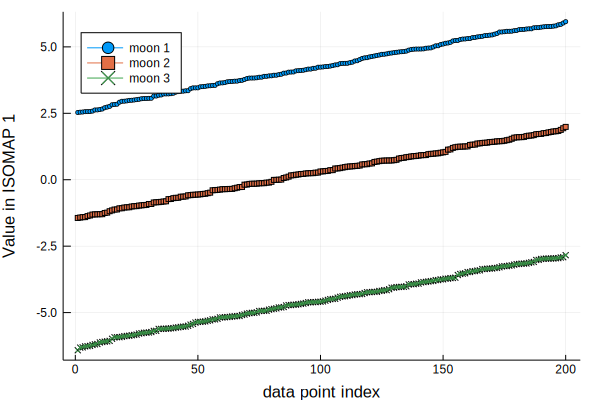

In [53]:
plot( sort(X[1:N,1]),           marker=:circle, markersize=2, label="moon 1", legend=:topleft)
plot!(sort(X[(N+1):(2*N),1]),   marker=:square, markersize=2, label="moon 2")
plot!(sort(X[(2*N+1):(3*N),1]), marker=:X, markersize=2, label="moon 3")
xlabel!("data point index")
ylabel!("Value in ISOMAP 1")